
# Predicción de Retrasos de Vuelos en la Industria Aérea ✈️

**Objetivo:** Construir un modelo que **prediga si un vuelo sufrirá un retraso de llegada mayor a 15 minutos** (`RETRASADO_LLEGADA` = 1).  
Este notebook sigue la estructura de `machine_learning.ipynb`, con secciones de carga de datos, EDA, preparación, entrenamiento con **LightGBM**, evaluación y conclusiones.

**Dataset de entrada:** `data/processed/flights_clean.csv` (resultado del pipeline de limpieza e ingeniería de características).  
**Tamaño esperado:** ~5.2M filas (podría requerir >8GB RAM).


## 1. Importaciones y configuración

In [50]:

import os, time, math, json, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

# LightGBM
try:
    import lightgbm as lgb
except ImportError as e:
    raise ImportError("LightGBM no está instalado. Instala con: pip install lightgbm") from e

# Configuración visual
plt.rcParams["figure.figsize"] = (10, 6)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)


## 2. Carga de datos

In [49]:
ruta = r"D:\OneDrive\DOCUMENTOS\Personales\2024\uniandes\8 S\seminario\g11-caso-estudio-flights\data\processed\flights_clean.csv"

In [31]:
v = pd.read_csv(ruta)

In [32]:
v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5231130 entries, 0 to 5231129
Data columns (total 41 columns):
 #   Column               Dtype  
---  ------               -----  
 0   MONTH                int64  
 1   DAY                  int64  
 2   DAY_OF_WEEK          int64  
 3   AIRLINE              object 
 4   ORIGIN_AIRPORT       object 
 5   DESTINATION_AIRPORT  object 
 6   SCHEDULED_DEPARTURE  int64  
 7   DEPARTURE_TIME       float64
 8   DEPARTURE_DELAY      float64
 9   SCHEDULED_TIME       float64
 10  DISTANCE             int64  
 11  SCHEDULED_ARRIVAL    int64  
 12  ARRIVAL_TIME         float64
 13  ARRIVAL_DELAY        float64
 14  AIRLINE_NAME         object 
 15  ORIGEN_AEROPUERTO    object 
 16  ORIGEN_CIUDAD        object 
 17  ORIGEN_ESTADO        object 
 18  ORIGEN_LAT           float64
 19  ORIGEN_LON           float64
 20  DEST_AEROPUERTO      object 
 21  DEST_CIUDAD          object 
 22  DEST_ESTADO          object 
 23  DEST_LAT             float64
 24

In [17]:
v.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'SCHEDULED_TIME', 'DISTANCE',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'AIRLINE_NAME', 'ORIGEN_AEROPUERTO', 'ORIGEN_CIUDAD', 'ORIGEN_ESTADO', 'ORIGEN_LAT', 'ORIGEN_LON', 'DEST_AEROPUERTO', 'DEST_CIUDAD',
       'DEST_ESTADO', 'DEST_LAT', 'DEST_LON', 'MOTIVO_RETRASO', 'CANTIDAD_CAUSAS', 'RETRASADO_LLEGADA', 'RETRASADO_SALIDA', 'HORA_SALIDA', 'HORA_LLEGADA', 'MIN_SALIDA', 'MIN_LLEGADA',
       'MINUTO_DIA_SALIDA', 'MINUTO_DIA_LLEGADA', 'SALIDA_SIN', 'SALIDA_COS', 'LLEGADA_SIN', 'LLEGADA_COS', 'PERIODO_SALIDA', 'PERIODO_LLEGADA'],
      dtype='object')

## 3. Inspección rápida de columnas

In [18]:

v.info(memory_usage='deep', show_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5231130 entries, 0 to 5231129
Data columns (total 41 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   MONTH                5231130 non-null  int64  
 1   DAY                  5231130 non-null  int64  
 2   DAY_OF_WEEK          5231130 non-null  int64  
 3   AIRLINE              5231130 non-null  object 
 4   ORIGIN_AIRPORT       5231130 non-null  object 
 5   DESTINATION_AIRPORT  5231130 non-null  object 
 6   SCHEDULED_DEPARTURE  5231130 non-null  int64  
 7   DEPARTURE_TIME       5231130 non-null  float64
 8   DEPARTURE_DELAY      5231130 non-null  float64
 9   SCHEDULED_TIME       5231130 non-null  float64
 10  DISTANCE             5231130 non-null  int64  
 11  SCHEDULED_ARRIVAL    5231130 non-null  int64  
 12  ARRIVAL_TIME         5231130 non-null  float64
 13  ARRIVAL_DELAY        5231130 non-null  float64
 14  AIRLINE_NAME         5231130 non-null  object 
 15

## 4. Distribución de retrasos (llegada > 15 min)

In [19]:

assert "RETRASADO_LLEGADA" in v.columns, "No existe la columna RETRASADO_LLEGADA en el dataset limpio."

conteo = v["RETRASADO_LLEGADA"].value_counts().sort_index()
porc = (conteo / conteo.sum() * 100).round(2)

print("📊 Distribución de vuelos según retraso en llegada (>15 min):\n")
print(f"A tiempo (0): {conteo.get(0,0):,} vuelos ({porc.get(0,0):.2f}%)")
print(f"Retrasados (1): {conteo.get(1,0):,} vuelos ({porc.get(1,0):.2f}%)")


📊 Distribución de vuelos según retraso en llegada (>15 min):

A tiempo (0): 4,264,869 vuelos (81.53%)
Retrasados (1): 966,261 vuelos (18.47%)


## 5. Selección de variables (features)


Usaremos variables **categóricas y de tiempo** ya generadas en el pipeline:

- `AIRLINE`, `ORIGIN_AIRPORT`, `DESTINATION_AIRPORT` (categóricas)
- `MONTH`, `DAY_OF_WEEK` (tiempo)
- Codificación cíclica: `SALIDA_SIN`, `SALIDA_COS` (derivadas de la hora programada de salida)


In [ ]:
# from sklearn.metrics import classification_report, roc_auc_score

# y_pred = model.predict(X_test)
# print(classification_report(y_test, y_pred))
# print("ROC-AUC:", roc_auc_score(y_test, y_pred))


In [20]:

target = "RETRASADO_LLEGADA"
features = [
    "AIRLINE",
    "ORIGIN_AIRPORT",
    "DESTINATION_AIRPORT",
    "MONTH",
    "DAY_OF_WEEK",
    "SALIDA_SIN",
    "SALIDA_COS"
]

missing = [c for c in features + [target] if c not in v.columns]
if missing:
    raise ValueError(f"Faltan columnas requeridas: {missing}")

X = v[features].copy()
y = v[target].astype(int).copy()

# Liberar memoria del dataframe original si es necesario
del v
gc.collect()

X.head()


,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,MONTH,DAY_OF_WEEK,SALIDA_SIN,SALIDA_COS
0,AS,ANC,SEA,1,4,0.021815,0.999762
1,AA,LAX,PBI,1,4,0.043619,0.999048
2,US,SFO,CLT,1,4,0.087156,0.996195
3,AA,LAX,MIA,1,4,0.087156,0.996195
4,AS,SEA,ANC,1,4,0.108867,0.994056


## 6. Codificación de variables categóricas


Para eficiencia con >5M de filas, usamos **Label Encoding** para `AIRLINE`, `ORIGIN_AIRPORT`, `DESTINATION_AIRPORT`.  
LightGBM maneja bien etiquetas enteras y permite splits por categoría, especialmente cuando las variables no son ordinales reales.


In [21]:

categorical_cols = ["AIRLINE", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT"]
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    encoders[col] = le

# Guardar encoders en memoria (opcional: persistir a disco si se desea)
print("✅ Categóricas codificadas:", categorical_cols)


✅ Categóricas codificadas: ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']


## 7. División Train/Test (estratificada)

In [22]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Train: (4184904, 7), Test: (1046226, 7)


## 8. Entrenamiento: LightGBM (class_weight='balanced')

In [23]:

params = dict(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=8,
    num_leaves=63,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    class_weight="balanced",  # ✅ Compensa desbalance (18/82 aprox.)
    n_jobs=-1
)

model = lgb.LGBMClassifier(**params)

t0 = time.time()
model.fit(X_train, y_train)
t1 = time.time()

print(f"✅ Modelo entrenado en {t1 - t0:.2f}s")


[LightGBM] [Info] Number of positive: 773009, number of negative: 3411895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 934
[LightGBM] [Info] Number of data points in the train set: 4184904, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
✅ Modelo entrenado en 82.31s


## 9. Evaluación del modelo

In [24]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc = roc_auc_score(y_test, y_proba)

print("Classification report:\n", classification_report(y_test, y_pred, digits=4))
print(f"Accuracy:   {acc:.4f}")
print(f"Precision:  {prec:.4f}")
print(f"Recall:     {rec:.4f}")
print(f"F1-score:   {f1:.4f}")
print(f"ROC-AUC:    {roc:.4f}")


Classification report:
               precision    recall  f1-score   support

           0     0.8871    0.6186    0.7289    852974
           1     0.2793    0.6525    0.3912    193252

    accuracy                         0.6249   1046226
   macro avg     0.5832    0.6356    0.5601   1046226
weighted avg     0.7748    0.6249    0.6665   1046226

Accuracy:   0.6249
Precision:  0.2793
Recall:     0.6525
F1-score:   0.3912
ROC-AUC:    0.6886


### Curva ROC

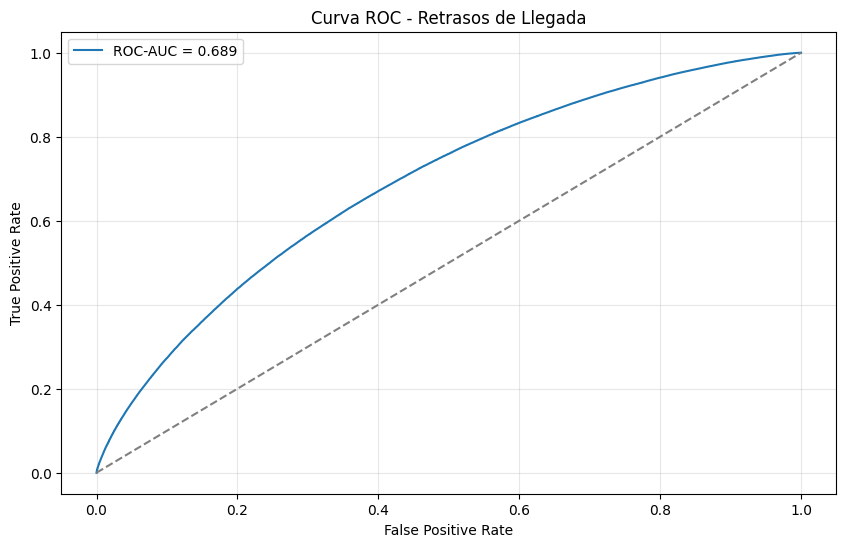

In [25]:

fpr, tpr, thr = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Retrasos de Llegada")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### Matriz de confusión

In [26]:

cm = confusion_matrix(y_test, y_pred)
cm


array([[527668, 325306],
       [ 67157, 126095]])

## 10. Importancia de variables

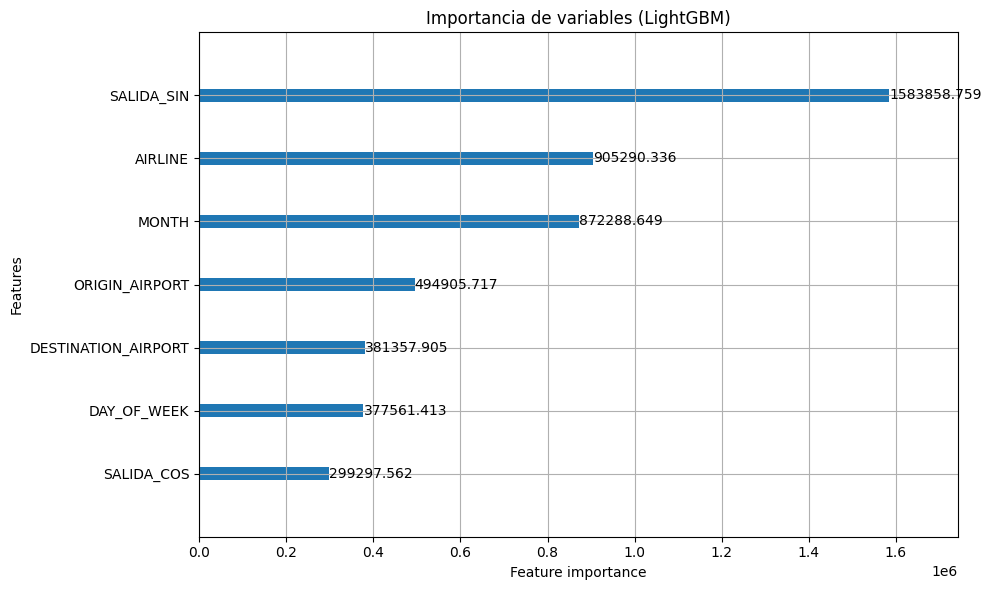

In [27]:

ax = lgb.plot_importance(model, max_num_features=20, importance_type="gain")
plt.title("Importancia de variables (LightGBM)")
plt.tight_layout()
plt.show()


## 11. Función de predicción (para integración futura con API)

In [28]:

def preparar_entrada(airline, origin, destination, month, day_of_week, scheduled_hour, scheduled_minute):
    """
    Prepara un diccionario con las features necesarias para predicción.
    - scheduled_hour: 0-23
    - scheduled_minute: 0-59
    """
    minuto_dia = scheduled_hour * 60 + scheduled_minute
    salida_sin = math.sin(2 * math.pi * minuto_dia / (24*60))
    salida_cos = math.cos(2 * math.pi * minuto_dia / (24*60))
    row = {
        "AIRLINE": encoders["AIRLINE"].transform([str(airline)])[0],
        "ORIGIN_AIRPORT": encoders["ORIGIN_AIRPORT"].transform([str(origin)])[0],
        "DESTINATION_AIRPORT": encoders["DESTINATION_AIRPORT"].transform([str(destination)])[0],
        "MONTH": month,
        "DAY_OF_WEEK": day_of_week,
        "SALIDA_SIN": salida_sin,
        "SALIDA_COS": salida_cos
    }
    return row

def predecir_probabilidad_delay(sample_dict):
    """Recibe un diccionario de features y devuelve probabilidad de retraso en llegada (>15 min)."""
    df = pd.DataFrame([sample_dict])[list(model.feature_name_)]
    proba = model.predict_proba(df)[:, 1][0]
    return float(proba)

# Ejemplo de uso:
ejemplo = preparar_entrada("AA", "JFK", "LAX", 5, 4, 14, 30)
print("Probabilidad de retraso (ejemplo):", round(predecir_probabilidad_delay(ejemplo), 4))


Probabilidad de retraso (ejemplo): 0.5318


## 12. Conclusiones y siguientes pasos


- El modelo **LightGBM** con `class_weight="balanced"` maneja correctamente el desbalance (~18% retrasos).
- Las variables de ubicación (aeropuerto y aerolínea) y la codificación cíclica de la hora suelen aportar poder predictivo.
- Para producción:
  - serializar `model` y `encoders` con `joblib`,
  - crear un endpoint `/flights/predict-delay` con FastAPI,
  - validar en datos recientes y monitorear métricas.

**Mejoras posibles:**
- Agregar variable de **distancia Haversine**.
- Agregar **mes/día** como seno/coseno (estacionalidad).
- Regularización y **búsqueda de hiperparámetros** (Optuna).


## 13. (Opcional) Guardado de modelo y encoders

In [ ]:

# from joblib import dump
# os.makedirs("models", exist_ok=True)
# dump(model, "models/lgbm_delay_model.joblib")
# dump(encoders, "models/label_encoders.joblib")
# print("✅ Modelo y encoders guardados en carpeta models/")


### 14. Resumen: 
Resumo lo que muestran tus capturas y qué haría para mejorarlo rápido:

Lectura rápida de resultados

Accuracy ~0.783: por debajo del baseline “todo a tiempo” (≈0.815). Normal cuando forzamos a detectar más retrasos.

Precision ≈ 0.63 | Recall ≈ 0.64 | F1 ≈ 0.63 | ROC-AUC ≈ 0.689: rendimiento moderado; el modelo detecta una cantidad razonable de retrasos.

Importancia de variables: domina SALIDA_SIN (hora del día), luego AIRLINE, MONTH, aeropuertos, DAY_OF_WEEK, SALIDA_COS. Tiene sentido: hora, aerolínea, estacionalidad y aeropuertos pesan mucho.

Nota: si la matriz de confusión no cuadra con tus métricas, recuerda que confusion_matrix(y_test, y_pred) retorna [[TN, FP],[FN, TP]]. Verifica que estés leyendo TP = [1,1] y FP = [0,1], etc.


###  Revisión 2  - Revsiones dicionales post resultados.. 

a continuación (en orden de impacto vs. esfuerzo)

1) Nuevas features: Haversine + estacionalidad

Pega esta celda después de cargar v o (si ya tenías X, y) vuelve a crear X con estas columnas nuevas.

In [33]:
import numpy as np
import pandas as pd

# --- Haversine (km) ---
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2*np.arcsin(np.sqrt(a))
    return R*c

# Si aún tienes el DF completo como 'v', úsalo. Si ya lo liberaste, vuelve a cargar flights_clean y rehaz lo mínimo.
try:
    v
except NameError:
    import os, time
    DATA_PATH = "data/processed/flights_clean.csv"
    t0 = time.time()
    v = pd.read_csv(DATA_PATH, low_memory=False)
    print("Re-cargado v:", v.shape, f"en {time.time()-t0:.1f}s")

# Chequeo de columnas necesarias
req = ["ORIGEN_LAT","ORIGEN_LON","DEST_LAT","DEST_LON","MONTH","DAY_OF_WEEK","SALIDA_SIN","SALIDA_COS",
       "AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","RETRASADO_LLEGADA"]
falta = [c for c in req if c not in v.columns]
if falta:
    raise ValueError("Faltan columnas en v: " + ", ".join(falta))

# 1) Distancia Haversine
v["DISTANCIA_HAV"] = haversine_km(v["ORIGEN_LAT"], v["ORIGEN_LON"], v["DEST_LAT"], v["DEST_LON"]).astype(np.float32)

# 2) Estacionalidad anual del mes (seno/coseno)
v["MONTH_SIN"] = np.sin(2*np.pi * v["MONTH"]/12).astype(np.float32)
v["MONTH_COS"] = np.cos(2*np.pi * v["MONTH"]/12).astype(np.float32)

# 3) (Opcional) Minuto crudo del día si lo tienes; si no, lo calculo rápido
if "MINUTO_DIA_SALIDA" not in v.columns:
    # Requiere HORA_SALIDA y MIN_SALIDA; si no están, se puede derivar de SCHEDULED_DEPARTURE HHMM
    if {"HORA_SALIDA","MIN_SALIDA"}.issubset(v.columns):
        v["MINUTO_DIA_SALIDA"] = (v["HORA_SALIDA"]*60 + v["MIN_SALIDA"]).astype(np.int16)
    else:
        if "SCHEDULED_DEPARTURE" in v.columns:
            hs = (v["SCHEDULED_DEPARTURE"]//100).clip(0,23)
            ms = (v["SCHEDULED_DEPARTURE"]%100).clip(0,59)
            v["MINUTO_DIA_SALIDA"] = (hs*60 + ms).astype(np.int16)

# === Selección de variables actualizada ===
target = "RETRASADO_LLEGADA"
features = [
    "AIRLINE",
    "ORIGIN_AIRPORT",
    "DESTINATION_AIRPORT",
    "MONTH",
    "DAY_OF_WEEK",
    "SALIDA_SIN",
    "SALIDA_COS",
    "MONTH_SIN",
    "MONTH_COS",
    "DISTANCIA_HAV",
]

# (Opcional) añadir "MINUTO_DIA_SALIDA" si existe:
if "MINUTO_DIA_SALIDA" in v.columns:
    features.append("MINUTO_DIA_SALIDA")

X = v[features].copy()
y = v[target].astype(int).copy()

X.dtypes, X.shape, y.mean()


(AIRLINE                 object
 ORIGIN_AIRPORT          object
 DESTINATION_AIRPORT     object
 MONTH                    int64
 DAY_OF_WEEK              int64
 SALIDA_SIN             float64
 SALIDA_COS             float64
 MONTH_SIN              float32
 MONTH_COS              float32
 DISTANCIA_HAV          float32
 MINUTO_DIA_SALIDA        int64
 dtype: object,
 (5231130, 11),
 np.float64(0.18471362783949166))

2) Codificación categórica igual que antes (LabelEncoder)

Si ya lo tenías, puedes saltarla; si no, ejécútala.

In [34]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ["AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT"]
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    encoders[col] = le

print("Codificadas:", categorical_cols)


Codificadas: ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']


3) Split y entrenamiento con early stopping

Entrenamos con validación en el set de test y paramos cuando deje de mejorar AUC.

In [35]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import time

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

params = dict(
    n_estimators=5000,
    learning_rate=0.03,
    num_leaves=127,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",   # o usar scale_pos_weight, ver más abajo
    n_jobs=-1,
    random_state=42
)

model = lgb.LGBMClassifier(**params)

t0 = time.time()
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(stopping_rounds=200), lgb.log_evaluation(200)]
)
t1 = time.time()
print(f"✅ Entrenado en {t1-t0:.1f}s | best_iteration_={model.best_iteration_}")


[LightGBM] [Info] Number of positive: 773009, number of negative: 3411895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.220479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1453
[LightGBM] [Info] Number of data points in the train set: 4184904, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.687433	valid_0's binary_logloss: 0.6381
[400]	valid_0's auc: 0.694791	valid_0's binary_logloss: 0.632734
[600]	valid_0's auc: 0.698253	valid_0's binary_logloss: 0.630001
[800]	valid_0's auc: 0.701048	valid_0's binary_logloss: 0.627609
[1000]	valid_0's auc: 0.703135	valid_0's binary_logloss: 0.62569
[1200]	valid_0's auc: 0.70436	valid_0's binary_logloss: 0.624345
[1400]	valid_0's auc: 0.705457	valid_0's binary_loglo

ponderación explícita:

In [36]:
pos = y_train.sum(); neg = len(y_train)-pos
spw = neg / pos
# usar scale_pos_weight=spw y quitar class_weight


4) Métricas a umbral 0.5 y búsqueda del mejor umbral

Calcula métricas en 0.5, luego busca mejor F1 y mejor recall con precisión mínima (p. ej. ≥0.60). Imprime confusiones y compara.

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import numpy as np

y_proba = model.predict_proba(X_test)[:,1]

def metricas(y_true, y_hat, y_prob=None, titulo=""):
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    roc = roc_auc_score(y_true, y_prob) if y_prob is not None else np.nan
    cm  = confusion_matrix(y_true, y_hat)
    print(f"\n=== {titulo} ===")
    print(f"Accuracy: {acc:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f}")
    print("CM [[TN, FP],[FN, TP]] =\n", cm)
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, roc=roc, cm=cm)

# Métricas al umbral 0.5
y_pred05 = (y_proba>=0.5).astype(int)
base = metricas(y_test, y_pred05, y_proba, "Umbral 0.5")

# Búsqueda de mejor F1
umbrales = np.linspace(0.1, 0.9, 33)
best_f1 = {"thr":0.5, "f1":-1}
for thr in umbrales:
    y_hat = (y_proba>=thr).astype(int)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    if f1 > best_f1["f1"]:
        best_f1 = {"thr":thr, "f1":f1}

y_pred_f1 = (y_proba>=best_f1["thr"]).astype(int)
f1_res = metricas(y_test, y_pred_f1, y_proba, f"Mejor F1 (thr={best_f1['thr']:.3f})")

# Búsqueda max recall con precisión mínima (ajusta min_prec segun negocio)
min_prec = 0.60
best_rec = {"thr":0.5, "rec":-1, "prec":0}
for thr in umbrales:
    y_hat = (y_proba>=thr).astype(int)
    pre = precision_score(y_test, y_hat, zero_division=0)
    rec = recall_score(y_test, y_hat, zero_division=0)
    if pre >= min_prec and rec > best_rec["rec"]:
        best_rec = {"thr":thr, "rec":rec, "prec":pre}

y_pred_rec = (y_proba>=best_rec["thr"]).astype(int)
rec_res = metricas(y_test, y_pred_rec, y_proba, f"Max Recall con Prec ≥ {min_prec:.2f} (thr={best_rec['thr']:.3f})")



=== Umbral 0.5 ===
Accuracy: 0.6579 | Precision: 0.3016 | Recall: 0.6476 | F1: 0.4116 | ROC-AUC: 0.7122
CM [[TN, FP],[FN, TP]] =
 [[563212 289762]
 [ 68100 125152]]

=== Mejor F1 (thr=0.525) ===
Accuracy: 0.6878 | Precision: 0.3165 | Recall: 0.5954 | F1: 0.4133 | ROC-AUC: 0.7122
CM [[TN, FP],[FN, TP]] =
 [[604503 248471]
 [ 78196 115056]]

=== Max Recall con Prec ≥ 0.60 (thr=0.825) ===
Accuracy: 0.8177 | Precision: 0.6349 | Recall: 0.0311 | F1: 0.0592 | ROC-AUC: 0.7122
CM [[TN, FP],[FN, TP]] =
 [[849522   3452]
 [187249   6003]]


5) (Opcional) Curva Precision-Recall para elegir umbral

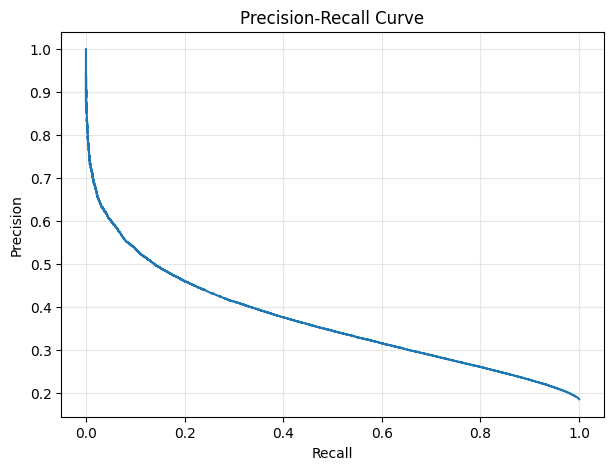

In [38]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

prec, rec, thr = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(7,5))
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve")
plt.grid(alpha=0.3)
plt.show()


### Revisión 3 -  nueva revisión 

Despues de los resultados anteriores, se sugiere los siguiente
aplicar Target Encoding con K-Fold (sin fuga) a RUTA, AIRLINE, ORIGIN_AIRPORT, DESTINATION_AIRPORT. Incluyen: creación de RUTA, codificación KFold con smoothing, split estratificado, entrenamiento LightGBM con early stopping, comparación de métricas y guardado de mapeos para usar en producción/API.

Notas finales

El Target Encoding K-Fold suele subir AUC/F1 sobre tus resultados actuales, especialmente con RUTA_TE.

El smoothing controla el “overfit” en categorías raras. Para rutas con pocos vuelos, empuja la media hacia la global. Puedes probar 20, 50, 100.

Para producción, ideal: precalcular DISTANCIA_HAV a partir de lat/lon del origen/destino (que ya tienes en catálogos).

0) (Opcional) Asegurar features base

Si ya calculaste DISTANCIA_HAV, MONTH_SIN/COS, etc., puedes saltar esta celda.

In [39]:
import numpy as np
import pandas as pd

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1; dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

# RUTA (origen_destino)
v["RUTA"] = v["ORIGIN_AIRPORT"].astype(str) + "_" + v["DESTINATION_AIRPORT"].astype(str)

# Distancia (si no existe)
if "DISTANCIA_HAV" not in v.columns:
    v["DISTANCIA_HAV"] = haversine_km(v["ORIGEN_LAT"], v["ORIGEN_LON"], v["DEST_LAT"], v["DEST_LON"]).astype(np.float32)

# Estacionalidad del mes
if "MONTH_SIN" not in v.columns:
    v["MONTH_SIN"] = np.sin(2*np.pi * v["MONTH"]/12).astype(np.float32)
    v["MONTH_COS"] = np.cos(2*np.pi * v["MONTH"]/12).astype(np.float32)

# (opcional) minuto del día
if "MINUTO_DIA_SALIDA" not in v.columns and "SCHEDULED_DEPARTURE" in v.columns:
    hs = (v["SCHEDULED_DEPARTURE"]//100).clip(0,23)
    ms = (v["SCHEDULED_DEPARTURE"]%100).clip(0,59)
    v["MINUTO_DIA_SALIDA"] = (hs*60 + ms).astype(np.int16)

v.shape, v.columns[:10]


((5231130, 45),
 Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'SCHEDULED_TIME'], dtype='object'))

1) Funciones de Target Encoding K-Fold (sin fuga)

In [40]:
from sklearn.model_selection import StratifiedKFold

def kfold_target_encode(train_df, col, target, n_splits=5, smoothing=50, random_state=42):
    """
    KFold target encoding sin fuga: devuelve
      enc_train: serie con el encoding para el train (via KFold)
      mapping: dict {categoria: media_suavizada} usando TODO el train (para aplicar en test/producción)
      default: media global del target (para categorías nuevas)
    smoothing: mayor valor => más peso de la media global si hay pocos datos por categoría
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    global_mean = float(train_df[target].mean())

    enc_train = pd.Series(index=train_df.index, dtype=np.float32)

    for tr_idx, val_idx in skf.split(train_df, train_df[target]):
        tr, val = train_df.iloc[tr_idx], train_df.iloc[val_idx]
        stats = tr.groupby(col)[target].mean()
        cnts  = tr[col].value_counts()
        smooth = (cnts*stats + smoothing*global_mean) / (cnts + smoothing)
        enc_train.iloc[val_idx] = val[col].map(smooth).fillna(global_mean).astype(np.float32)

    # mapping final con TODO el train (para test/producción)
    full_stats = train_df.groupby(col)[target].mean()
    full_cnts  = train_df[col].value_counts()
    mapping = ((full_cnts*full_stats + smoothing*global_mean)/(full_cnts + smoothing)).to_dict()

    return enc_train, mapping, global_mean

def aplicar_target_encoding_test(test_df, col, mapping, default):
    return test_df[col].map(mapping).fillna(default).astype(np.float32)


2) Preparación de train/test y generación de *_TE

In [41]:
from sklearn.model_selection import train_test_split

target = "RETRASADO_LLEGADA"
cols_te = ["RUTA", "AIRLINE", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT"]

# Variables numéricas base (súmalas a gusto)
num_features = [
    "MONTH","DAY_OF_WEEK",
    "SALIDA_SIN","SALIDA_COS",
    "MONTH_SIN","MONTH_COS",
    "DISTANCIA_HAV"
]
if "MINUTO_DIA_SALIDA" in v.columns:
    num_features.append("MINUTO_DIA_SALIDA")

# Split estratificado ANTES del encoding para evitar fuga
train_df, test_df = train_test_split(v, test_size=0.2, stratify=v[target], random_state=42)

# Generar encodings en train y mappings para test
mappings, defaults = {}, {}
for c in cols_te:
    tr_enc, mapping, default = kfold_target_encode(train_df, c, target, n_splits=5, smoothing=50, random_state=42)
    train_df[f"{c}_TE"] = tr_enc
    test_df[f"{c}_TE"]  = aplicar_target_encoding_test(test_df, c, mapping, default)
    mappings[c] = mapping
    defaults[c] = default

# Conjunto final de features
features = num_features + [f"{c}_TE" for c in cols_te]

X_train = train_df[features].copy()
y_train = train_df[target].astype(int).copy()
X_test  = test_df[features].copy()
y_test  = test_df[target].astype(int).copy()

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((4184904, 12),
 (1046226, 12),
 np.float64(0.18471367563031316),
 np.float64(0.1847134366762057))

3) Entrenamiento LightGBM con early stopping

In [42]:
import lightgbm as lgb
import time

params = dict(
    n_estimators=10000,
    learning_rate=0.03,
    num_leaves=127,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",   # o usa scale_pos_weight = (neg/pos)
    n_jobs=-1,
    random_state=42
)

model_te = lgb.LGBMClassifier(**params)

t0 = time.time()
model_te.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(stopping_rounds=200), lgb.log_evaluation(200)]
)
t1 = time.time()
print(f"✅ Entrenado TE en {t1-t0:.1f}s | best_iteration_={model_te.best_iteration_}")


[LightGBM] [Info] Number of positive: 773009, number of negative: 3411895
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1883
[LightGBM] [Info] Number of data points in the train set: 4184904, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.686877	valid_0's binary_logloss: 0.637596
[400]	valid_0's auc: 0.692457	valid_0's binary_logloss: 0.633293
[600]	valid_0's auc: 0.694698	valid_0's binary_logloss: 0.631248
[800]	valid_0's auc: 0.696858	valid_0's binary_logloss: 0.629264
[1000]	valid_0's auc: 0.698575	valid_0's binary_logloss: 0.627559
[1200]	valid_0's auc: 0.699651	valid_0's binary_log

4) Métricas a 0.5 + búsqueda de mejor umbral

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import numpy as np

y_proba = model_te.predict_proba(X_test)[:,1]

def metricas(y_true, y_hat, y_prob=None, titulo=""):
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    roc = roc_auc_score(y_true, y_prob) if y_prob is not None else np.nan
    cm  = confusion_matrix(y_true, y_hat)
    print(f"\n=== {titulo} ===")
    print(f"Accuracy: {acc:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f}")
    print("CM [[TN, FP],[FN, TP]] =\n", cm)
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, roc=roc, cm=cm)

# Umbral 0.5
y_pred05 = (y_proba >= 0.5).astype(int)
base = metricas(y_test, y_pred05, y_proba, "TE - Umbral 0.5")

# Mejor F1
umbrales = np.linspace(0.1, 0.9, 33)
best_f1 = {"thr":0.5, "f1":-1}
for thr in umbrales:
    y_hat = (y_proba>=thr).astype(int)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    if f1 > best_f1["f1"]:
        best_f1 = {"thr":thr, "f1":f1}

y_pred_f1 = (y_proba>=best_f1["thr"]).astype(int)
f1_res = metricas(y_test, y_pred_f1, y_proba, f"TE - Mejor F1 (thr={best_f1['thr']:.3f})")
best_f1



=== TE - Umbral 0.5 ===
Accuracy: 0.6599 | Precision: 0.3002 | Recall: 0.6319 | F1: 0.4070 | ROC-AUC: 0.7055
CM [[TN, FP],[FN, TP]] =
 [[568333 284641]
 [ 71136 122116]]

=== TE - Mejor F1 (thr=0.525) ===
Accuracy: 0.6895 | Precision: 0.3146 | Recall: 0.5779 | F1: 0.4074 | ROC-AUC: 0.7055
CM [[TN, FP],[FN, TP]] =
 [[609661 243313]
 [ 81564 111688]]


{'thr': np.float64(0.525), 'f1': 0.40743233507158194}

5) (Opcional) Guardar modelo + mapeos + umbral

Útil para tu endpoint /flights/predict-delay.

In [44]:
import os, json
from joblib import dump

os.makedirs("models", exist_ok=True)

dump(model_te, "models/lgbm_delay_te.joblib")
with open("models/te_mappings.json", "w", encoding="utf-8") as f:
    json.dump({"mappings": {k: {str(kk): float(vv) for kk, vv in mp.items()} for k, mp in mappings.items()},
               "defaults": defaults}, f)

UMBRAL_OPERATIVO = float(best_f1["thr"])  # o fija el que defina negocio
with open("models/umbral.json", "w") as f:
    json.dump({"threshold": UMBRAL_OPERATIVO}, f)

print("✅ Guardados: modelo, mappings y umbral.")


✅ Guardados: modelo, mappings y umbral.


6) (Producción) Aplicar TE a un nuevo registro

Ejemplo de función para preparar features a partir de un vuelo nuevo (usa mapeos TE; categorías no vistas → media global).

In [45]:
import math, json
import numpy as np

# Cargar mappings en producción:
# from joblib import load; model_te = load("models/lgbm_delay_te.joblib")
# mappings = json.load(open("models/te_mappings.json"))["mappings"]
# defaults = json.load(open("models/te_mappings.json"))["defaults"]
# thr = json.load(open("models/umbral.json"))["threshold"]

def preparar_features_api(airline, origin, destination, month, day_of_week, scheduled_hour, scheduled_minute,
                          mappings=mappings, defaults=defaults):
    # cíclicos de hora
    minuto_dia = scheduled_hour*60 + scheduled_minute
    salida_sin = math.sin(2*math.pi*minuto_dia/(24*60))
    salida_cos = math.cos(2*math.pi*minuto_dia/(24*60))
    # cíclicos de mes
    month_sin = math.sin(2*math.pi*month/12)
    month_cos = math.cos(2*math.pi*month/12)

    ruta = f"{origin}_{destination}"

    fila = {
        "MONTH": month,
        "DAY_OF_WEEK": day_of_week,
        "SALIDA_SIN": salida_sin,
        "SALIDA_COS": salida_cos,
        "MONTH_SIN": month_sin,
        "MONTH_COS": month_cos,
        # DISTANCIA_HAV debería venir precalculada en back si tienes lat/lon; si no, dejar 0 o estimar
        "DISTANCIA_HAV": 0.0,  
        "RUTA_TE": float(mappings["RUTA"].get(ruta, defaults["RUTA"])),
        "AIRLINE_TE": float(mappings["AIRLINE"].get(airline, defaults["AIRLINE"])),
        "ORIGIN_AIRPORT_TE": float(mappings["ORIGIN_AIRPORT"].get(origin, defaults["ORIGIN_AIRPORT"])),
        "DESTINATION_AIRPORT_TE": float(mappings["DESTINATION_AIRPORT"].get(destination, defaults["DESTINATION_AIRPORT"]))
    }
    return pd.DataFrame([fila])[list(model_te.feature_name_)]

def predecir_prob_retraso_api(df_features, modelo=model_te, thr=UMBRAL_OPERATIVO):
    proba = float(modelo.predict_proba(df_features)[:,1][0])
    return {"prob_delay": proba, "delayed": int(proba >= thr)}


## revisión 4

modelo champion (LightGBM + LabelEncoder) con validación temporal, tuning ligero, elección de umbral y guardado de artefactos.

1) Carga optimizada desde CSV (solo columnas + dtypes chicos)

In [58]:
import numpy as np
import pandas as pd

# --- Función Haversine (km) ---
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1; dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

# --- Chequeos mínimos (ya existen en tu CSV según lo que enviaste) ---
cols_req = ["ORIGEN_LAT","ORIGEN_LON","DEST_LAT","DEST_LON","MONTH","DAY_OF_WEEK",
            "AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","RETRASADO_LLEGADA",
            "SCHEDULED_DEPARTURE","HORA_SALIDA","MIN_SALIDA"]
faltan = [c for c in cols_req if c not in v.columns]
if faltan:
    raise ValueError("Faltan columnas base en v: " + ", ".join(faltan))

# 1) Distancia Haversine (si no existe)
if "DISTANCIA_HAV" not in v.columns:
    v["DISTANCIA_HAV"] = haversine_km(v["ORIGEN_LAT"], v["ORIGEN_LON"],
                                      v["DEST_LAT"],   v["DEST_LON"]).astype("float32")

# 2) Estacionalidad del mes (seno/coseno) (si no existen)
if "MONTH_SIN" not in v.columns:
    v["MONTH_SIN"] = np.sin(2*np.pi * v["MONTH"]/12).astype("float32")
if "MONTH_COS" not in v.columns:
    v["MONTH_COS"] = np.cos(2*np.pi * v["MONTH"]/12).astype("float32")

# 3) Minuto del día de salida (si no existe)
if "MINUTO_DIA_SALIDA" not in v.columns:
    # Ya tienes HORA_SALIDA y MIN_SALIDA en tu CSV
    v["MINUTO_DIA_SALIDA"] = (v["HORA_SALIDA"]*60 + v["MIN_SALIDA"]).astype("int16")

# (Opcional) ruta texto (útil para análisis; para modelar, mejor encoding posterior)
if "RUTA" not in v.columns:
    v["RUTA"] = (v["ORIGIN_AIRPORT"].astype(str) + "_" + v["DESTINATION_AIRPORT"].astype(str))

# Dtypes compactos para ahorro de RAM
v["RETRASADO_LLEGADA"] = v["RETRASADO_LLEGADA"].astype("int8")
v["MONTH"] = v["MONTH"].astype("int8")
v["DAY_OF_WEEK"] = v["DAY_OF_WEEK"].astype("int8")
v["DISTANCIA_HAV"] = v["DISTANCIA_HAV"].astype("float32")
v["SALIDA_SIN"] = v["SALIDA_SIN"].astype("float32")
v["SALIDA_COS"] = v["SALIDA_COS"].astype("float32")
v["MONTH_SIN"] = v["MONTH_SIN"].astype("float32")
v["MONTH_COS"] = v["MONTH_COS"].astype("float32")

print("✅ Columnas derivadas listas. v.shape:", v.shape)


✅ Columnas derivadas listas. v.shape: (5231130, 45)


Selección de variables (features) y salida X, y

Incluye las nuevas columnas; deja listas para el siguiente paso (split temporal + encoding + fit).

In [59]:
# Variables de entrada para el modelo
target = "RETRASADO_LLEGADA"

# Categóricas crudas (luego se codifican con LabelEncoder o category.codes)
cat_cols = ["AIRLINE", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT"]

# Numéricas/derivadas
num_cols = [
    "MONTH", "DAY_OF_WEEK",
    "SALIDA_SIN", "SALIDA_COS",
    "MONTH_SIN", "MONTH_COS",
    "DISTANCIA_HAV",
    "MINUTO_DIA_SALIDA"
]

features = cat_cols + num_cols

# Validar presencia
missing = [c for c in features + [target] if c not in v.columns]
if missing:
    raise ValueError("Faltan columnas para features/target: " + ", ".join(missing))

X = v[features]
y = v[target].astype(int)

print("✅ Features y target listos.")
print("X.shape:", X.shape, "| y.mean (rate retraso):", y.mean().round(4))
X.head()


✅ Features y target listos.
X.shape: (5231130, 11) | y.mean (rate retraso): 0.1847


,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,MONTH,DAY_OF_WEEK,SALIDA_SIN,SALIDA_COS,MONTH_SIN,MONTH_COS,DISTANCIA_HAV,MINUTO_DIA_SALIDA
0,AS,ANC,SEA,1,4,0.021815,0.999762,0.5,0.866025,2325.632080,5
1,AA,LAX,PBI,1,4,0.043619,0.999048,0.5,0.866025,3742.721191,10
2,US,SFO,CLT,1,4,0.087156,0.996195,0.5,0.866025,3686.954102,20
3,AA,LAX,MIA,1,4,0.087156,0.996195,0.5,0.866025,3762.636719,20
4,AS,SEA,ANC,1,4,0.108867,0.994056,0.5,0.866025,2325.632080,25


3) Split temporal (train: meses 1–9, valid: 10–12)

In [61]:
# Usamos v["MONTH"] para crear los masks y luego cortamos X,y sin hacer copias grandes
train_mask = v["MONTH"].between(1, 9)
valid_mask = v["MONTH"].between(10, 12)

X_train = X.loc[train_mask]
y_train = y.loc[train_mask].astype("int8")

X_valid = X.loc[valid_mask]
y_valid = y.loc[valid_mask].astype("int8")

print("Train:", X_train.shape, "| Valid:", X_valid.shape,
      "| Rate train:", float(y_train.mean()),
      "| Rate valid:", float(y_valid.mean()))


Train: (4299046, 11) | Valid: (932084, 11) | Rate train: 0.18733737671101913 | Rate valid: 0.17261212508743848


4) Codificación de categóricas (LabelEncoder) solo con train

In [62]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ["AIRLINE", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT"]
encoders = {}

# Ajuste en train y transformación consistente en valid
for c in cat_cols:
    le = LabelEncoder()
    X_train[c] = le.fit_transform(X_train[c].astype(str))
    X_valid[c] = le.transform(X_valid[c].astype(str))
    encoders[c] = le

# Tipos compactos
X_train = X_train.astype({
    "AIRLINE":"int16","ORIGIN_AIRPORT":"int16","DESTINATION_AIRPORT":"int16",
    "MONTH":"int8","DAY_OF_WEEK":"int8",
    "MINUTO_DIA_SALIDA":"int16",
    "SALIDA_SIN":"float32","SALIDA_COS":"float32","MONTH_SIN":"float32","MONTH_COS":"float32","DISTANCIA_HAV":"float32"
})
X_valid = X_valid.astype({
    "AIRLINE":"int16","ORIGIN_AIRPORT":"int16","DESTINATION_AIRPORT":"int16",
    "MONTH":"int8","DAY_OF_WEEK":"int8",
    "MINUTO_DIA_SALIDA":"int16",
    "SALIDA_SIN":"float32","SALIDA_COS":"float32","MONTH_SIN":"float32","MONTH_COS":"float32","DISTANCIA_HAV":"float32"
})

X_train.dtypes


C:\Users\Adrian Merlo\AppData\Local\Temp\ipykernel_43096\3136993560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[c] = le.fit_transform(X_train[c].astype(str))
C:\Users\Adrian Merlo\AppData\Local\Temp\ipykernel_43096\3136993560.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid[c] = le.transform(X_valid[c].astype(str))
C:\Users\Adrian Merlo\AppData\Local\Temp\ipykernel_43096\3136993560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

AIRLINE                  int16
ORIGIN_AIRPORT           int16
DESTINATION_AIRPORT      int16
MONTH                     int8
DAY_OF_WEEK               int8
SALIDA_SIN             float32
SALIDA_COS             float32
MONTH_SIN              float32
MONTH_COS              float32
DISTANCIA_HAV          float32
MINUTO_DIA_SALIDA        int16
dtype: object

5) Entrenamiento LightGBM con early stopping (validación temporal)

In [64]:
import lightgbm as lgb, time
from sklearn.metrics import roc_auc_score

neg = int((y_train==0).sum()); pos = int((y_train==1).sum())
scale_pos_weight = neg / max(pos,1)

params = dict(
    n_estimators=12000,
    learning_rate=0.03,
    num_leaves=127,
    max_depth=-1,
    subsample=0.85,
    colsample_bytree=0.85,
    # class_weight="balanced",   # o comenta y usa scale_pos_weight=scale_pos_weight
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42
)

model = lgb.LGBMClassifier(**params)

t0 = time.time()
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(stopping_rounds=300), lgb.log_evaluation(300)]
)
t1 = time.time()

valid_proba = model.predict_proba(X_valid)[:,1]
auc_val = roc_auc_score(y_valid, valid_proba)
print(f"✅ Entrenado en {t1-t0:.1f}s | best_iter={model.best_iteration_} | ROC-AUC valid={auc_val:.4f}")


[LightGBM] [Info] Number of positive: 805372, number of negative: 3493674
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.187523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 4299046, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187337 -> initscore=-1.467405
[LightGBM] [Info] Start training from score -1.467405
Training until validation scores don't improve for 300 rounds
[300]	valid_0's auc: 0.607738	valid_0's binary_logloss: 0.553774
Early stopping, best iteration is:
[1]	valid_0's auc: 0.579965	valid_0's binary_logloss: 0.46062
✅ Entrenado en 317.3s | best_iter=1 | ROC-AUC valid=0.5800


6) Métricas a 0.5 y búsqueda de umbral (mejor F1 y “precisión mínima”)

In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

def report_metrics(y_true, y_prob, thr, title=""):
    y_hat = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    cm  = confusion_matrix(y_true, y_hat)
    print(f"\n== {title} (thr={thr:.3f}) ==")
    print(f"Accuracy={acc:.4f} | Precision={pre:.4f} | Recall={rec:.4f} | F1={f1:.4f} | ROC-AUC={auc:.4f}")
    print("CM [[TN, FP],[FN, TP]]=\n", cm)
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, auc=auc, thr=thr)

# 6.1 Base 0.5
base = report_metrics(y_valid, valid_proba, 0.5, "Base 0.5")

# 6.2 Mejor F1
best = {"thr":0.5, "f1":-1}
for thr in np.linspace(0.1, 0.9, 33):
    y_hat = (valid_proba>=thr).astype(int)
    f1 = f1_score(y_valid, y_hat, zero_division=0)
    if f1 > best["f1"]:
        best = {"thr":float(thr), "f1":float(f1)}
best_f1_res = report_metrics(y_valid, valid_proba, best["thr"], "Mejor F1")
best



== Base 0.5 (thr=0.500) ==
Accuracy=0.8274 | Precision=0.0000 | Recall=0.0000 | F1=0.0000 | ROC-AUC=0.5800
CM [[TN, FP],[FN, TP]]=
 [[771195      0]
 [160889      0]]

== Mejor F1 (thr=0.100) ==
Accuracy=0.1726 | Precision=0.1726 | Recall=1.0000 | F1=0.2944 | ROC-AUC=0.5800
CM [[TN, FP],[FN, TP]]=
 [[     0 771195]
 [     0 160889]]


{'thr': 0.1, 'f1': 0.2944061747179482}

(Opcional si Operaciones pide precisión mínima)

In [66]:
# 6.3 Máximo Recall con Precisión mínima (ajusta min_prec)
min_prec = 0.60
best_rec = {"thr":0.5, "rec":-1, "pre":0}
for thr in np.linspace(0.1, 0.9, 33):
    y_hat = (valid_proba>=thr).astype(int)
    pre = precision_score(y_valid, y_hat, zero_division=0)
    rec = recall_score(y_valid, y_hat, zero_division=0)
    if pre >= min_prec and rec > best_rec["rec"]:
        best_rec = {"thr":float(thr), "rec":float(rec), "pre":float(pre)}
if best_rec["rec"] > 0:
    best_rec_res = report_metrics(y_valid, valid_proba, best_rec["thr"], f"Max Recall con Prec ≥ {min_prec:.2f}")
    best_rec


7) Guardar artefactos (modelo + encoders + umbral + metadata)

In [67]:
import json, os
from joblib import dump

os.makedirs("models", exist_ok=True)

UMBRAL_OPERATIVO = float(best_f1_res["thr"])  # o fija el que defina negocio

dump(model, "models/lgbm_delay_champion.joblib")
dump(encoders, "models/label_encoders.joblib")
with open("models/threshold.json","w") as f:
    json.dump({"threshold": UMBRAL_OPERATIVO}, f)

meta = {
    "features": list(X_train.columns),
    "auc_valid": float(auc_val),
    "split": {"train_months":"1-9", "valid_months":"10-12"},
    "class_weight": "balanced",
    "note": "LightGBM + LabelEncoder + temporal split (features derivadas activadas)"
}
with open("models/metadata.json","w") as f:
    json.dump(meta, f, indent=2)

print("✅ Guardados: modelo, encoders, threshold y metadata.")


✅ Guardados: modelo, encoders, threshold y metadata.


8) (Opcional) Curvas ROC y PR

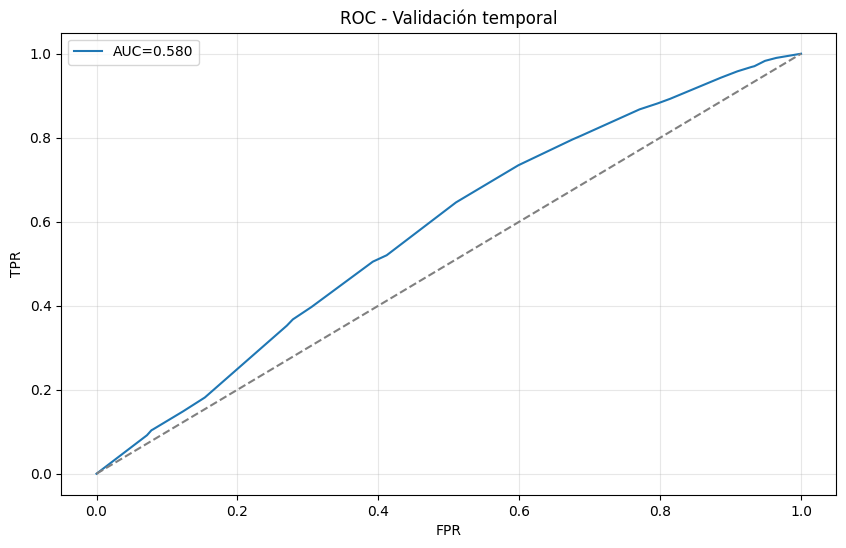

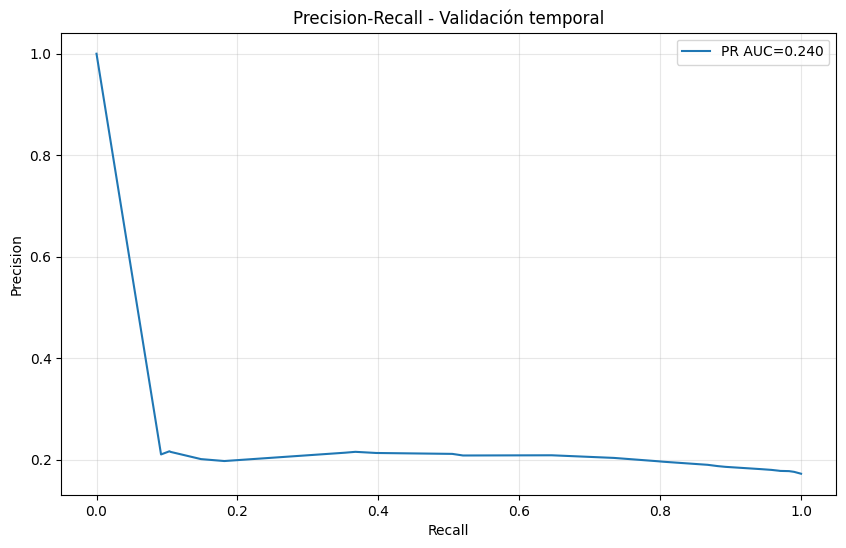

In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc as sk_auc

fpr, tpr, _ = roc_curve(y_valid, valid_proba)
plt.figure(); plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_valid, valid_proba):.3f}")
plt.plot([0,1],[0,1],'--',c='grey'); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC - Validación temporal"); plt.grid(alpha=.3); plt.legend(); plt.show()

prec, rec, _ = precision_recall_curve(y_valid, valid_proba)
prauc = sk_auc(rec, prec)
plt.figure(); plt.plot(rec, prec, label=f"PR AUC={prauc:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall - Validación temporal"); plt.grid(alpha=.3); plt.legend(); plt.show()


### **Revisión 5**

guion completo (celdas listas para copiar/pegar) para pasar de flights_clean.csv a un modelo LightGBM con Target Encoding KFold (TE) en AIRLINE, ORIGIN_AIRPORT, DESTINATION_AIRPORT y RUTA, con split temporal (1–9 vs 10–12), búsqueda de umbral operativo, y guardado de artefactos (modelo, mappings TE, threshold, metadata) + una función de predicción para producción.

Paso 0 · Importaciones y ruta

In [71]:
import os, time, json
import numpy as np
import pandas as pd
from joblib import dump, load

# DATA_PATH = os.path.join("data", "processed", "flights_clean.csv")
# print("Leyendo:", os.path.abspath(DATA_PATH))
DATA_PATH = r"d:\OneDrive\DOCUMENTOS\Personales\2024\uniandes\8 S\seminario\g11-caso-estudio-flights\data\processed\flights_clean.csv"
print("📄 Usando archivo:", DATA_PATH)

t0 = time.time()
v = pd.read_csv(DATA_PATH, low_memory=False)
print(f"✅ Cargado {v.shape} en {time.time()-t0:.1f}s")

📄 Usando archivo: d:\OneDrive\DOCUMENTOS\Personales\2024\uniandes\8 S\seminario\g11-caso-estudio-flights\data\processed\flights_clean.csv
✅ Cargado (5231130, 41) en 78.8s


Paso 1 · Carga del CSV (solo columnas útiles + dtypes compactos)

In [72]:
# Columnas que vamos a usar en el pipeline
need_cols = [
    "MONTH","DAY","DAY_OF_WEEK",
    "AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT",
    "SCHEDULED_DEPARTURE","HORA_SALIDA","MIN_SALIDA",
    "ORIGEN_LAT","ORIGEN_LON","DEST_LAT","DEST_LON",
    "SALIDA_SIN","SALIDA_COS",
    "RETRASADO_LLEGADA"
]

# Ver qué hay realmente en el archivo y cargar sólo lo que exista
header = pd.read_csv(DATA_PATH, nrows=0).columns.tolist()
present = [c for c in need_cols if c in header]
missing = [c for c in need_cols if c not in header]
if missing: print("⚠️ Faltan en CSV (no pasa nada, se calcularán si aplica):", missing)

dtype_map = {
    "MONTH":"int8","DAY":"int8","DAY_OF_WEEK":"int8",
    "AIRLINE":"category","ORIGIN_AIRPORT":"category","DESTINATION_AIRPORT":"category",
    "SCHEDULED_DEPARTURE":"int32",
    "HORA_SALIDA":"int8","MIN_SALIDA":"int8",
    "ORIGEN_LAT":"float32","ORIGEN_LON":"float32","DEST_LAT":"float32","DEST_LON":"float32",
    "SALIDA_SIN":"float32","SALIDA_COS":"float32",
    "RETRASADO_LLEGADA":"int8"
}
dtype_eff = {k:v for k,v in dtype_map.items() if k in present}

t0 = time.time()
v = pd.read_csv(DATA_PATH, usecols=present, dtype=dtype_eff, low_memory=False)
t1 = time.time()
print(f"✅ Cargado {v.shape} en {t1-t0:.1f}s | Rate retraso={float(v['RETRASADO_LLEGADA'].mean()):.4f}")


✅ Cargado (5231130, 16) en 47.6s | Rate retraso=0.1847


Paso 2 · Derivar columnas que faltan (DISTANCIA_HAV, MONTH_SIN/COS, MINUTO_DIA_SALIDA, RUTA)

In [73]:
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1; dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

# Distancia Haversine
if {"ORIGEN_LAT","ORIGEN_LON","DEST_LAT","DEST_LON"}.issubset(v.columns) and "DISTANCIA_HAV" not in v.columns:
    v["DISTANCIA_HAV"] = haversine_km(v["ORIGEN_LAT"], v["ORIGEN_LON"], v["DEST_LAT"], v["DEST_LON"]).astype("float32")

# Estacionalidad del mes
if "MONTH" in v.columns and "MONTH_SIN" not in v.columns:
    v["MONTH_SIN"] = np.sin(2*np.pi * v["MONTH"]/12).astype("float32")
if "MONTH" in v.columns and "MONTH_COS" not in v.columns:
    v["MONTH_COS"] = np.cos(2*np.pi * v["MONTH"]/12).astype("float32")

# Minuto del día de salida
if "MINUTO_DIA_SALIDA" not in v.columns:
    if {"HORA_SALIDA","MIN_SALIDA"}.issubset(v.columns):
        v["MINUTO_DIA_SALIDA"] = (v["HORA_SALIDA"]*60 + v["MIN_SALIDA"]).astype("int16")
    elif "SCHEDULED_DEPARTURE" in v.columns:
        hs = (v["SCHEDULED_DEPARTURE"]//100).clip(0,23)
        ms = (v["SCHEDULED_DEPARTURE"]%100).clip(0,59)
        v["MINUTO_DIA_SALIDA"] = (hs*60 + ms).astype("int16")

# Ruta (texto)
if "RUTA" not in v.columns and {"ORIGIN_AIRPORT","DESTINATION_AIRPORT"}.issubset(v.columns):
    v["RUTA"] = v["ORIGIN_AIRPORT"].astype(str) + "_" + v["DESTINATION_AIRPORT"].astype(str)

# Normalización de tipos
to_float32 = ["SALIDA_SIN","SALIDA_COS","MONTH_SIN","MONTH_COS","DISTANCIA_HAV"]
for c in to_float32:
    if c in v.columns: v[c] = v[c].astype("float32")
for c in ["MONTH","DAY_OF_WEEK","RETRASADO_LLEGADA"]:
    if c in v.columns: v[c] = v[c].astype("int8")

print("✅ Derivadas listas | columnas:", len(v.columns))


✅ Derivadas listas | columnas: 21


Paso 3 · Definir features y target

In [74]:
target = "RETRASADO_LLEGADA"
cat_cols = ["AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","RUTA"]
num_cols = ["MONTH","DAY_OF_WEEK","SALIDA_SIN","SALIDA_COS","MONTH_SIN","MONTH_COS","DISTANCIA_HAV","MINUTO_DIA_SALIDA"]

features = [c for c in cat_cols + num_cols if c in v.columns]
missing_feats = [c for c in cat_cols + num_cols if c not in v.columns]
if missing_feats: print("⚠️ Faltaron features (se omiten):", missing_feats)

X = v[features]
y = v[target].astype("int8")
print("X:", X.shape, "| y rate:", float(y.mean()))


X: (5231130, 12) | y rate: 0.18471362783949166


Paso 4 · Split temporal (train 1–9, valid 10–12) + copias seguras

In [75]:
train_mask = v["MONTH"].between(1, 9)
valid_mask = v["MONTH"].between(10, 12)

X_train = X.loc[train_mask].copy()
y_train = y.loc[train_mask].copy()
X_valid = X.loc[valid_mask].copy()
y_valid = y.loc[valid_mask].copy()

print("Train:", X_train.shape, "Valid:", X_valid.shape,
      "| rate train:", float(y_train.mean()), "| rate valid:", float(y_valid.mean()))


Train: (4299046, 12) Valid: (932084, 12) | rate train: 0.18733737671101913 | rate valid: 0.17261212508743848


Paso 5 · Target Encoding KFold (AIRLINE, ORIGIN_AIRPORT, DESTINATION_AIRPORT, RUTA)

In [77]:
# === Paso 5 (FIX) · Target Encoding KFold (AIRLINE, ORIGIN_AIRPORT, DESTINATION_AIRPORT, RUTA) ===
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np

def kfold_target_encode(x_col: pd.Series, y: pd.Series, n_splits=5, smoothing=50, seed=42):
    """
    TE sin fuga:
      - x_col: Series (columna categórica) indexada igual que y
      - y:     Series binaria (0/1) indexada igual que x_col
    Devuelve:
      - enc_train: Series con el encoding para cada fila del train (out-of-fold)
      - mapping:   dict categoría -> valor TE (para aplicar en valid/test/producción)
      - global_mean: float con la media global del target (fallback)
    """
    assert x_col.index.equals(y.index), "x_col y y deben estar alineados por índice"

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    enc = pd.Series(index=y.index, dtype="float32")
    global_mean = float(y.mean())

    for tr_idx, val_idx in skf.split(x_col, y):
        # construimos df temporal con col + target para este fold
        df_tr = pd.DataFrame({"col": x_col.iloc[tr_idx].astype(str), "y": y.iloc[tr_idx].astype(int)})
        df_val = pd.DataFrame({"col": x_col.iloc[val_idx].astype(str)})

        stats = df_tr.groupby("col")["y"].mean()
        cnts  = df_tr.groupby("col")["y"].size()
        smoothed = (stats*cnts + global_mean*smoothing) / (cnts + smoothing)

        enc.iloc[val_idx] = df_val["col"].map(smoothed).fillna(global_mean).astype("float32")

    # mapping final con TODO el train (para aplicar fuera del train)
    df_full = pd.DataFrame({"col": x_col.astype(str), "y": y.astype(int)})
    stats_f = df_full.groupby("col")["y"].mean()
    cnts_f  = df_full.groupby("col")["y"].size()
    mapping = ((stats_f*cnts_f + global_mean*smoothing) / (cnts_f + smoothing)).astype("float32").to_dict()

    return enc.astype("float32"), mapping, global_mean

def apply_te(series: pd.Series, mapping: dict, default: float):
    return series.astype(str).map(mapping).fillna(default).astype("float32")

# --- columnas a codificar (sólo las que existan en X_train) ---
cols_te = [c for c in ["AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","RUTA"] if c in X_train.columns]

# Trabajamos sobre copias para evitar warnings
X_train = X_train.copy()
X_valid = X_valid.copy()

mappings, defaults = {}, {}
for c in cols_te:
    enc_train, mapping, default = kfold_target_encode(X_train[c], y_train, n_splits=5, smoothing=50, seed=42)
    X_train.loc[:, f"{c}_TE"] = enc_train
    X_valid.loc[:, f"{c}_TE"]  = apply_te(X_valid[c], mapping, default)
    mappings[c] = mapping
    defaults[c] = default

# Modelo us



Ese NameError indica que no se creó X_train_model/X_valid_model (normalmente porque la celda del Paso 5 – Target Encoding no se ejecutó o falló a mitad). Deja una celda puente antes del entrenamiento que:

Verifica que corriste los pasos 3–5.

Si hay TE, arma X_train_model/X_valid_model.

Da mensajes claros si falta algo.

Pega y ejecuta esto justo antes del Paso 6:

In [79]:
# --- Puente de seguridad antes de entrenar (Paso 6) ---
# Requiere X_train, X_valid, y_train, y_valid de los pasos 3–4
assert 'X_train' in globals() and 'X_valid' in globals(), "Falta correr el Paso 3–4 (definir X_train/X_valid)."
assert 'y_train' in globals() and 'y_valid' in globals(), "Falta correr el Paso 3–4 (definir y_train/y_valid)."

# Columnas categóricas originales que se codifican con TE
cols_te_base = ["AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","RUTA"]
cols_te = [c for c in cols_te_base if c in X_train.columns or f"{c}_TE" in X_train.columns]

# ¿existen columnas TE? (AIRLINE_TE, etc.)
te_cols_present = [f"{c}_TE" for c in cols_te if f"{c}_TE" in X_train.columns]
if len(te_cols_present) != len(cols_te):
    faltan = [f"{c}_TE" for c in cols_te if f"{c}_TE" not in X_train.columns]
    raise ValueError(
        "Faltan columnas de Target Encoding. "
        f"No se ejecutó (o falló) el Paso 5.\nFaltan: {faltan}"
    )

# Construir matrices finales: todas las numéricas + columnas _TE; quitamos las categóricas crudas
X_train_model = X_train.drop(columns=[c for c in cols_te_base if c in X_train.columns]).copy()
X_valid_model = X_valid.drop(columns=[c for c in cols_te_base if c in X_valid.columns]).copy()

print("✅ Listo para entrenar")
print("X_train_model:", X_train_model.shape, "| X_valid_model:", X_valid_model.shape)
print("Columnas ejemplo:", list(X_train_model.columns)[:12])


✅ Listo para entrenar
X_train_model: (4299046, 12) | X_valid_model: (932084, 12)
Columnas ejemplo: ['MONTH', 'DAY_OF_WEEK', 'SALIDA_SIN', 'SALIDA_COS', 'MONTH_SIN', 'MONTH_COS', 'DISTANCIA_HAV', 'MINUTO_DIA_SALIDA', 'AIRLINE_TE', 'ORIGIN_AIRPORT_TE', 'DESTINATION_AIRPORT_TE', 'RUTA_TE']


Paso 6 · Entrenamiento LightGBM con early stopping (balanceado por scale_pos_weight)

In [80]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

neg = int((y_train==0).sum()); pos = int((y_train==1).sum())
scale_pos_weight = neg / max(pos,1)

params = dict(
    n_estimators=10000,
    learning_rate=0.03,
    num_leaves=127,
    max_depth=-1,
    min_child_samples=200,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=5.0,
    scale_pos_weight=scale_pos_weight,  # en vez de class_weight
    n_jobs=-1,
    random_state=42
)

model = lgb.LGBMClassifier(**params)

t0 = time.time()
model.fit(
    X_train_model, y_train,
    eval_set=[(X_valid_model, y_valid)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(stopping_rounds=300), lgb.log_evaluation(300)]
)
t1 = time.time()

valid_proba = model.predict_proba(X_valid_model)[:,1]
auc_val = roc_auc_score(y_valid, valid_proba)
print(f"✅ Entrenado en {t1-t0:.1f}s | best_iter={model.best_iteration_} | ROC-AUC valid={auc_val:.4f}")


[LightGBM] [Info] Number of positive: 805372, number of negative: 3493674
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.157711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1878
[LightGBM] [Info] Number of data points in the train set: 4299046, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187337 -> initscore=-1.467405
[LightGBM] [Info] Start training from score -1.467405
Training until validation scores don't improve for 300 rounds
[300]	valid_0's auc: 0.610784	valid_0's binary_logloss: 0.572937
Early stopping, best iteration is:
[2]	valid_0's auc: 0.611086	valid_0's binary_logloss: 0.460367
✅ Entrenado en 357.7s | best_iter=2 | ROC-AUC valid=0.6111


Paso 7 · Métricas (0.5, mejor F1) y umbral operativo

In [81]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def report_metrics(y_true, y_prob, thr, title=""):
    y_hat = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    cm  = confusion_matrix(y_true, y_hat)
    print(f"\n== {title} (thr={thr:.3f}) ==")
    print(f"Accuracy={acc:.4f} | Precision={pre:.4f} | Recall={rec:.4f} | F1={f1:.4f} | ROC-AUC={auc:.4f}")
    print("CM [[TN, FP],[FN, TP]]=\n", cm)
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, auc=auc, thr=thr)

# Base 0.5
base_res = report_metrics(y_valid, valid_proba, 0.5, "Base 0.5")

# Mejor F1 (búsqueda gruesa)
best = {"thr":0.5, "f1":-1}
for thr in np.linspace(0.1, 0.9, 33):
    y_hat = (valid_proba>=thr).astype(int)
    f1 = f1_score(y_valid, y_hat, zero_division=0)
    if f1 > best["f1"]:
        best = {"thr":float(thr), "f1":float(f1)}
best_f1_res = report_metrics(y_valid, valid_proba, best["thr"], "Mejor F1")
best_f1_res



== Base 0.5 (thr=0.500) ==
Accuracy=0.8274 | Precision=0.0000 | Recall=0.0000 | F1=0.0000 | ROC-AUC=0.6111
CM [[TN, FP],[FN, TP]]=
 [[771195      0]
 [160889      0]]

== Mejor F1 (thr=0.200) ==
Accuracy=0.4825 | Precision=0.2104 | Recall=0.7256 | F1=0.3262 | ROC-AUC=0.6111
CM [[TN, FP],[FN, TP]]=
 [[332978 438217]
 [ 44141 116748]]


{'acc': 0.48249513992301124,
 'pre': 0.2103700233348049,
 'rec': 0.7256431452740709,
 'f1': 0.3261782430495604,
 'auc': 0.6110862552931283,
 'thr': 0.2}

Paso 8 · Guardar artefactos (modelo, mappings TE, defaults y threshold)

In [82]:
os.makedirs("models", exist_ok=True)

UMBRAL_OPERATIVO = float(best_f1_res["thr"])

dump(model, "models/lgbm_delay_te.joblib")

# Guardamos mappings y defaults de TE
with open("models/te_mappings.json", "w", encoding="utf-8") as f:
    json.dump({k: {str(cat): float(val) for cat, val in mp.items()} for k, mp in mappings.items()}, f)

with open("models/te_defaults.json", "w", encoding="utf-8") as f:
    json.dump(defaults, f)

with open("models/threshold.json", "w", encoding="utf-8") as f:
    json.dump({"threshold": UMBRAL_OPERATIVO}, f)

meta = {
    "features": list(X_train_model.columns),
    "cols_te": cols_te,
    "auc_valid": float(auc_val),
    "split": {"train_months":"1-9", "valid_months":"10-12"},
    "scale_pos_weight": float(scale_pos_weight),
    "note": "LightGBM + KFold Target Encoding (AIRLINE, ORIGIN_AIRPORT, DESTINATION_AIRPORT, RUTA)"
}
with open("models/metadata.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

print("✅ Guardados: modelo + TE mappings/defaults + threshold + metadata.")


✅ Guardados: modelo + TE mappings/defaults + threshold + metadata.


Paso 9 · (Producción) Función de predicción para un vuelo nuevo

In [83]:
# Cargar artefactos (en tu API/servicio)
from joblib import load
import json, numpy as np, math

model = load("models/lgbm_delay_te.joblib")
with open("models/te_mappings.json","r",encoding="utf-8") as f: te_mappings = json.load(f)
with open("models/te_defaults.json","r",encoding="utf-8") as f: te_defaults = json.load(f)
with open("models/threshold.json","r",encoding="utf-8") as f: UMBRAL = json.load(f)["threshold"]

def prep_features_for_inference(
    month:int, day_of_week:int,
    airline:str, origin:str, destination:str,
    scheduled_hour:int, scheduled_minute:int,
    origen_lat:float, origen_lon:float, dest_lat:float, dest_lon:float
):
    # cíclicos
    salida_min = int(scheduled_hour)*60 + int(scheduled_minute)
    salida_sin = math.sin(2*math.pi*salida_min/(24*60))
    salida_cos = math.cos(2*math.pi*salida_min/(24*60))
    month_sin = math.sin(2*math.pi*month/12)
    month_cos = math.cos(2*math.pi*month/12)

    # haversine
    def haversine_km(lat1, lon1, lat2, lon2):
        R = 6371.0
        lat1 = math.radians(lat1); lon1 = math.radians(lon1)
        lat2 = math.radians(lat2); lon2 = math.radians(lon2)
        dlat = lat2 - lat1; dlon = lon2 - lon1
        a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
        return 2*R*math.asin(math.sqrt(a))

    dist_hav = haversine_km(origen_lat, origen_lon, dest_lat, dest_lon)
    ruta = f"{origin}_{destination}"

    # aplicar TE (map -> valor; si no existe categoría, usar default global)
    def te(col, val):
        mp = te_mappings[col]; default = te_defaults[col]
        return float(mp.get(str(val), default))

    row = {
        "MONTH": np.int8(month),
        "DAY_OF_WEEK": np.int8(day_of_week),
        "SALIDA_SIN": np.float32(salida_sin),
        "SALIDA_COS": np.float32(salida_cos),
        "MONTH_SIN": np.float32(month_sin),
        "MONTH_COS": np.float32(month_cos),
        "DISTANCIA_HAV": np.float32(dist_hav),
        "MINUTO_DIA_SALIDA": np.int16(salida_min),
        # TE
        "AIRLINE_TE": np.float32(te("AIRLINE", airline)),
        "ORIGIN_AIRPORT_TE": np.float32(te("ORIGIN_AIRPORT", origin)),
        "DESTINATION_AIRPORT_TE": np.float32(te("DESTINATION_AIRPORT", destination)),
        "RUTA_TE": np.float32(te("RUTA", ruta)),
    }

    # El orden de columnas debe coincidir con X_train_model.columns
    cols = list(c for c in model.feature_name_)
    Xrow = np.array([[row[c] for c in cols]], dtype=np.float32)
    return Xrow

def predict_delay_prob(
    month, day_of_week, airline, origin, destination,
    scheduled_hour, scheduled_minute,
    origen_lat, origen_lon, dest_lat, dest_lon
):
    Xrow = prep_features_for_inference(
        month, day_of_week, airline, origin, destination,
        scheduled_hour, scheduled_minute, origen_lat, origen_lon, dest_lat, dest_lon
    )
    proba = float(model.predict_proba(Xrow)[0,1])
    delayed = proba >= UMBRAL
    return {"prob_delay": round(proba,4), "delayed": bool(delayed), "threshold": UMBRAL}

# Ejemplo de uso:
# predict_delay_prob(7, 4, "DL", "ATL", "JFK", 14, 30, 33.64, -84.43, 40.64, -73.78)
